<a href="https://colab.research.google.com/github/mcchhh/FinalYearProject-AI/blob/main/Iteration_5_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.8 MB/s eta 0:00:00


In [2]:
!pip install tabulate

In [3]:
import os
import shutil

# Image processing
import pandas as pd
import numpy as np
from PIL import Image
import cv2

# Data visualisation
import matplotlib.pyplot as plt

# Genetic Algorithm with DEAP
from deap import base, creator, tools, algorithms
import random

# Connect to google drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to your data
floor_plan_path = '/content/drive/MyDrive/FYPCoding/Dataset_5rooms'
bagua_map_path = '/content/drive/MyDrive/FYPCoding/blackHatBaguaMap.jpg'
output_folder_path = '/content/drive/MyDrive/FYPCoding/maindoor_5room_dataset'  # Output folder for filtered floor plans



Mounted at /content/drive


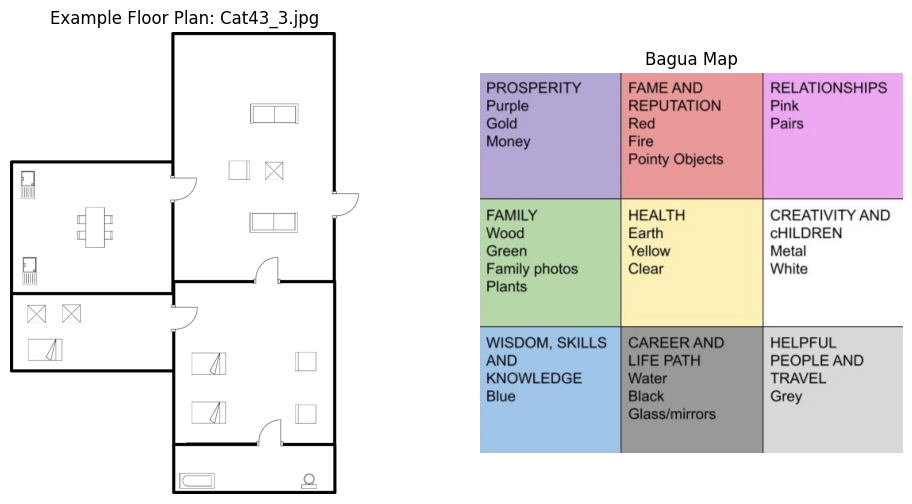

In [4]:
# Function to load images from a folder into a dictionary
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images[filename] = img
    return images

# Function to display images side by side using matplotlib
def display_images_side_by_side(image1, title1, image2, title2):
    # Convert BGR images to RGB for displaying with matplotlib
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(image1_rgb)
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(image2_rgb)
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.show()

# Load floor plans and Bagua map
floor_plans = load_images_from_folder(floor_plan_path)
bagua_map = cv2.imread(bagua_map_path)

# Display an example floor plan and Bagua map if they exist
if floor_plans:
    example_floor_plan_filename = random.choice(list(floor_plans.keys()))
    example_floor_plan = floor_plans[example_floor_plan_filename]
    if bagua_map is not None:
        display_images_side_by_side(example_floor_plan, f'Example Floor Plan: {example_floor_plan_filename}', bagua_map, 'Bagua Map')
    else:
        print("Bagua Map image not found at the specified path.")
else:
    print("No floor plans found in the specified folder")

# Filter and save floor plans

In [5]:
def detect_main_door(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to binary
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours of shapes in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store door contours
    door_contours = []

    # Iterate through contours
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the contour is a quarter circle
        if len(approx) >= 5:  # Check if it's a curve (a quarter circle approximation)
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter * perimeter)

            # circularity threshold based on quarter circle shape
            if 0.6 < circularity < 0.9:
                door_contours.append(contour)

    # Return the contours of detected doors
    return door_contours


In [6]:
# Update 'filter_and_save_floor_plans' to use te updated 'detect_main_door' function

def filter_and_save_floor_plans(dataset_path, output_folder_path):
    # Ensure output folder exists, create it if necessary
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # Iterate through each image in the dataset folder
    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(dataset_path, filename)
            floor_plan = cv2.imread(image_path)

            if floor_plan is not None:
                # Check if there is exactly one main door in the floor plan
                door_contours = detect_main_door(floor_plan)
                if len(door_contours) == 1:
                    # Copy the image to the output folder
                    shutil.copy(image_path, os.path.join(output_folder_path, filename))

    print("Filtering and saving completed.")

# Call the function to filter and save floor plans
filter_and_save_floor_plans(floor_plan_path, output_folder_path)


Filtering and saving completed.


# Preprocessing & alignment of the Feng Shui map

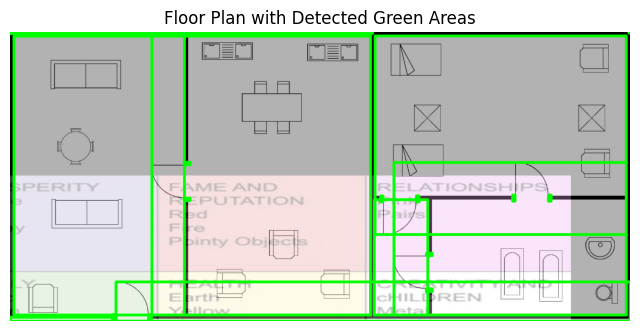

In [7]:
def find_front_door(image):
    door_contours = detect_main_door(image)

    if len(door_contours) != 1:
        print(f"Error: Detected {len(door_contours)} doors instead of 1.")
        return None  # Return None if there's not exactly one main door

    # Get the bounding box of the detected door contour
    x, y, w, h = cv2.boundingRect(door_contours[0])

    # Return the center of the detected door as the front door location
    front_door_x = x + w // 2
    front_door_y = y + h // 2
    return front_door_x, front_door_y


# Function to align BTB map with the front door of the floor plan
def align_btb_map_with_front_door(floor_plan, btb_map):
    front_door_coords = find_front_door(floor_plan)
    if front_door_coords is None:
        raise ValueError("No front door detected or multiple doors detected in the floor plan.")

    front_door_x, front_door_y = front_door_coords
    height, width, _ = floor_plan.shape

    # Resize BTB map to match the floor plan size
    btb_map_resized = cv2.resize(btb_map, (width, height))

    # Align BTB map so its north direction matches the front door
    btb_map_center_x = width // 2
    btb_map_center_y = 0  # Assuming north is at the top

    # Calculate the shifts needed to align the BTB map
    shift_x = front_door_x - btb_map_center_x
    shift_y = front_door_y - btb_map_center_y

    # Create the translation matrix
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Apply the translation to the BTB map
    aligned_btb_map = cv2.warpAffine(btb_map_resized, translation_matrix, (width, height))

    return aligned_btb_map


def overlay_btb_map(floor_plan, aligned_btb_map):
    overlay = cv2.addWeighted(floor_plan, 0.7, aligned_btb_map, 0.3, 0)
    return overlay


def detect_green_areas_and_draw_rectangles_bgr2gray(overlay_image):
    # Convert the overlay image to grayscale
    gray_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to get only green areas
    _, thresholded = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Find contours of green areas
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw green rectangles around detected green areas
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(overlay_image, (x, y), (x + w, y + h), (0, 255, 0), 10)  # Green rectangle

    return overlay_image


def display_image(image, title='Image'):
    """Function to display an image using matplotlib."""
    # Convert BGR image (OpenCV format) to RGB format (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 10))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


if bagua_map is not None:
    floor_plans = [f for f in os.listdir(output_folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    if len(floor_plans) >= 11:
        # Process a specific floor plan
        floor_plan_filename = floor_plans[3]  # Ensure there are at least 11 floor plans
        image_path = os.path.join(output_folder_path, floor_plan_filename)
        floor_plan = cv2.imread(image_path)

        if floor_plan is not None:
            try:
                # Align BTB map with front door of floor plan
                aligned_btb_map = align_btb_map_with_front_door(floor_plan, bagua_map)

                # Overlay the aligned BTB map on the floor plan
                overlay_image = overlay_btb_map(floor_plan, aligned_btb_map)

                # Detect green areas and draw rectangles
                result_image = detect_green_areas_and_draw_rectangles_bgr2gray(overlay_image)

                # Display the result
                display_image(result_image, 'Floor Plan with Detected Green Areas')
            except ValueError as e:
                print(f"Error processing {floor_plan_filename}: {e}")
    else:
        print("Not enough floor plans found in the specified folder.")
else:
    print("BTB Map image not found.")


# 3. Optimisation algorithm implementation

Tasks:
- Define fitness function: evaluate room layouts based on feng shui principles
- implement evolutionary algorithms: genetic algorithm

gen	nevals	avg    	std    	min    	max    
0  	65    	4.11955	0.70208	2.68094	6.02835
1  	36    	4.76277	0.523341	3.42858	6.02835
2  	36    	5.22065	0.611047	3.06014	6.45688
3  	41    	5.74651	0.441677	4.28462	6.62288
4  	39    	6.05401	0.446766	4.04705	6.88251
5  	28    	6.28697	0.442193	4.28641	7.14747
6  	42    	6.45802	0.62318 	3.5759 	7.23152
7  	37    	6.70853	0.549228	3.7098 	7.48942
8  	35    	6.92742	0.416659	5.39409	7.48942
9  	42    	7.05668	0.400068	5.4027 	7.48942
10 	35    	7.19439	0.364705	5.49647	7.48942
11 	42    	7.25653	0.391229	5.52192	7.58971
12 	42    	7.28527	0.534881	5.01269	7.61778
13 	40    	7.32027	0.449685	5.42538	7.61778
14 	42    	7.29082	0.446011	5.90775	7.61778
15 	31    	7.4288 	0.346464	5.66803	7.61778
16 	39    	7.50954	0.295073	6.14333	7.61778
17 	40    	7.42802	0.407974	5.86517	7.61778
18 	27    	7.43121	0.424675	5.69664	7.61778
19 	30    	7.44235	0.470684	5.02567	7.67248
20 	35    	7.49914	0.360635	6.02925	7.61778
21 	38    	7.51559	0.283269	6.1219

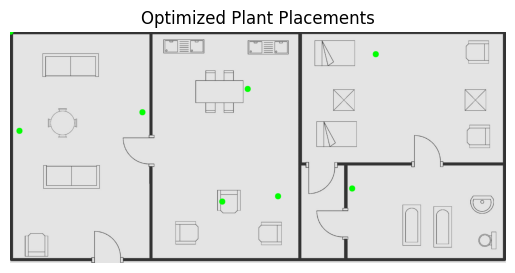

In [8]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Constants
NUM_PLANTS = 8
POP_SIZE = 65 # population size
NGEN = 100
CXPB, MUTPB = 0.5, 0.2

# Extract height and width from floor_plan
height, width, _ = floor_plan.shape # Extract width here

green_areas = np.zeros((height, width), dtype=np.uint8)

# Define constants for your specific criteria
DOOR_DISTANCE_THRESHOLD = 20
CORNER_DISTANCE_THRESHOLD = 60
SUNLIGHT_MAP = np.random.rand(height, width)

# Mock doors locations for demonstration
doors = [(100, 100), (200, 200)]

# DEAP setup
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_pos", lambda: (random.randint(0, width-1), random.randint(0, height-1)))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_pos, n=NUM_PLANTS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness evaluation function
def evaluate(individual):
    score = 0
    for pos in individual:
        x, y = pos

        # Ensure the plant is within the boundary
        if x < 0 or x >= width or y < 0 or y >= height:
            continue  # Skip positions that are out of bounds

        # Reward if placed in green area
        if green_areas[y, x] == 1:
            score += 1

        # Penalize if too close to a door
        for door in doors:
          distance_to_door = np.linalg.norm(np.array(pos) - np.array(door))
          if distance_to_door < DOOR_DISTANCE_THRESHOLD:
            score -= 10  # To increase penalty for being too close to a door

        # Reward if placed near a corner (Example using the top-left corner)
        if np.linalg.norm(np.array(pos)) < CORNER_DISTANCE_THRESHOLD:
            score += 1

        # Reward based on sunlight availability
        score += SUNLIGHT_MAP[y, x]  # Assuming higher values mean more sunlight

        # Add more criteria as needed
    return score,


toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("select", tools.selTournament, tournsize=3)

# Custom mutation function to respect (x, y) tuple structure
def custom_mutation(individual, indpb):
  for i in range(len(individual)):
        if random.random() < indpb:
            x_new = random.randint(0, width - 1)
            y_new = random.randint(0, height - 1)
            individual[i] = (x_new, y_new)
  return individual,

toolbox.register("mutate", custom_mutation, indpb=0.2)

# Running the Genetic Algorithm
def run_ga():
    population = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, log = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                          stats=stats, halloffame=hof, verbose=True)

    return population, log, hof

# Visualization function
def visualize_layout(floor_plan, layout):
    # Display a copy of the floor plan to draw on
    display_plan = floor_plan.copy()

    # Optional: Enhance floor plan visibility if it's too light
    display_plan = cv2.addWeighted(display_plan, 0.7, np.zeros_like(display_plan), 0, 50)

    # overlay the plant placements on the floor plan
    for x, y in layout:
        cv2.circle(display_plan, (x, y), 15, (0, 255, 0), -1)  # green circles for plant placements

    # Display the image with both the floor plan and the plants
    plt.imshow(cv2.cvtColor(display_plan, cv2.COLOR_BGR2RGB))
    plt.title('Optimized Plant Placements')
    plt.axis('off')
    plt.show()

# Main Execution
population, logs, hall_of_fame = run_ga()
best_layout = hall_of_fame[0]

# Visualize the best layout on the actual floor plan
visualize_layout(floor_plan, best_layout)

In [9]:
from google.colab import drive
import pandas as pd
import numpy as np
import time
from tabulate import tabulate  # Import tabulate

# Mount Google Drive
drive.mount('/content/drive')

def run_ga_with_metrics(iterations):
    best_fitness_scores = []
    average_fitness_scores = []
    execution_times = []

    for _ in range(iterations):
        start_time = time.time()
        population, log, hof = run_ga()
        end_time = time.time()

        execution_time = end_time - start_time
        execution_times.append(execution_time)

        # Collecting fitness scores
        best_fitness = hof[0].fitness.values[0]
        best_fitness_scores.append(best_fitness)

        # Calculate average fitness score for each generation
        avg_fitness = np.mean(log.select("avg"))
        average_fitness_scores.append(avg_fitness)

    # Calculate mean and median of best fitness scores
    mean_best_fitness = np.mean(best_fitness_scores)
    median_best_fitness = np.median(best_fitness_scores)

    # Create a DataFrame with the metrics
    metrics_df = pd.DataFrame({
        "Iteration": range(1, iterations + 1),
        "Best Fitness Score": best_fitness_scores,
        "Average Fitness Score": average_fitness_scores,
        "Execution Time (s)": execution_times
    })

    # Add mean and median of best fitness scores
    mean_median_df = pd.DataFrame({
        "Iteration": ["Mean", "Median"],
        "Best Fitness Score": [mean_best_fitness, median_best_fitness],
        "Average Fitness Score": [np.nan, np.nan],
        "Execution Time (s)": [np.nan, np.nan]
    })

    # Combine DataFrames
    metrics_df = pd.concat([metrics_df, mean_median_df], ignore_index=True)

    # Print metrics summary in table format
    print("Metrics Summary:")
    print(tabulate(metrics_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))

# Run GA with metrics
run_ga_with_metrics(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
gen	nevals	avg    	std     	min    	max    
0  	65    	4.04646	0.867433	2.02543	6.19539
1  	41    	4.67296	0.780786	2.88994	6.50334
2  	38    	5.26677	0.682123	3.56848	6.88096
3  	52    	5.93373	0.648626	4.65708	7.22782
4  	42    	6.37825	0.53112 	5.0628 	7.58651
5  	44    	6.68436	0.460788	5.15216	7.58651
6  	42    	6.83993	0.469999	4.58885	7.81787
7  	43    	6.89471	0.589535	4.06587	7.81787
8  	37    	7.1989 	0.418609	5.41029	7.90477
9  	38    	7.25951	0.516638	5.12268	7.93483
10 	33    	7.51512	0.40292 	5.33775	7.96948
11 	40    	7.66744	0.338183	6.0127 	8.06759
12 	39    	7.586  	0.516985	5.59013	8.07311
13 	44    	7.82829	0.303086	6.78402	8.74828
14 	36    	7.80998	0.51807 	5.53082	8.74886
15 	37    	7.92133	0.400842	6.42865	8.74828
16 	32    	7.99717	0.566284	5.26417	9.02015
17 	35    	8.11823	0.664978	5.72771	9.02015
18 	49    	8.30784	0.720682	5.62418